In [1]:
#-----------------------------------------
# importamos los paquetes que vamos a usar
#-----------------------------------------

import pypulse as pulsar

import matplotlib.mlab as mlab
import matplotlib as mpl
import matplotlib.pyplot as plt     # para graficar
from matplotlib import pyplot

from scipy.optimize import curve_fit
import scipy.integrate as integrate

import math
import decimal
import numpy as np
import glob                         # para hacer listas de archivo
import subprocess                   # para usar subprocesos

import pandas as pd

import os
import shutil

In [2]:
def f(x, n):
    
    S0 = np.mean(sn)
    return [( ((x_i  * n / S0)**(n)) / (x_i * math.gamma(n)) )  * math.exp( (-1.0 * x_i * n) / S0 ) * np.heaviside(x_i, 0) for x_i in x]

In [3]:
def f2(x, n, norm):
    
    S0 = np.mean(sn)
    return [( ((x_i  * n / S0)**(n)) / (x_i * math.gamma(n)) )  * math.exp( (-1.0 * x_i * n) / S0 ) * np.heaviside(x_i, 0) * norm for x_i in x]

In [31]:
ant = "A1"
t_min = 5000

datafile = "results_" + ant + "_subints_" + str(t_min) + ".txt"
files = np.loadtxt( datafile , skiprows=0 , dtype=str , usecols=(0) )
sn_obs = np.loadtxt( datafile , skiprows=0 , dtype=float , usecols=(1) )
t_obs = np.loadtxt( datafile , skiprows=0 , dtype=float , usecols=(2) )

In [32]:
sn = []
t_max = np.amax(t_obs)

k=0
for k in range(len(files)):

    sn.append(float(sn_obs[k] / math.sqrt(t_max / t_obs[k]) ))


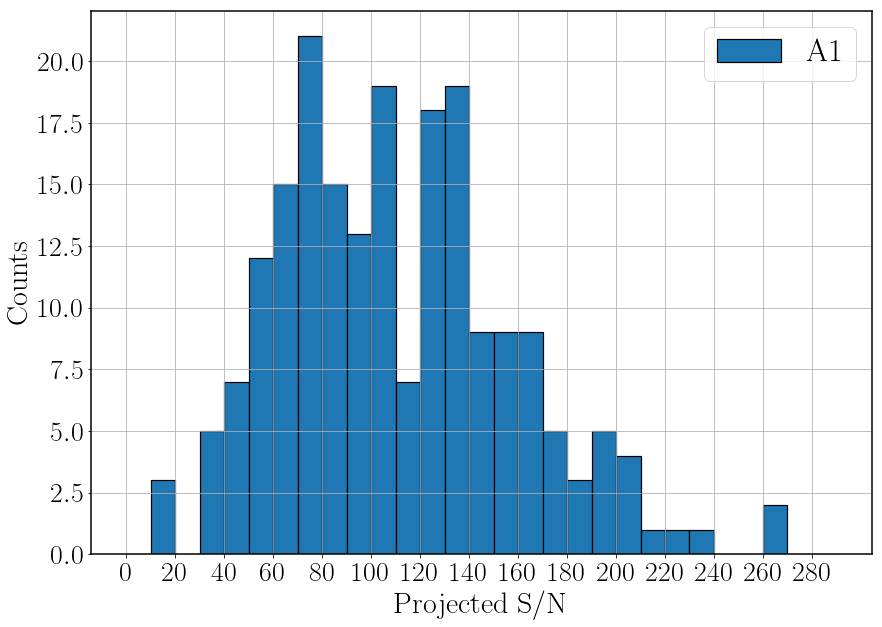

In [33]:
#------------------------------------
# Graficamos
#------------------------------------
        
plt.close()

# Set the fonts. Always use big fonts.
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 30,
        "font.size": 28,
        "axes.linewidth": 1.5,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 32,
        "xtick.labelsize": 28,
        "ytick.labelsize": 28,
}
# Update the fonts
mpl.rcParams.update(nice_fonts)


plt.figure(figsize=(14,10))
plt.grid()
    
bin_width = 10
plt.xticks(np.arange(0, 300 , 20))
bins = np.arange(0, 300 , bin_width)

plt.hist(sn, bins, edgecolor='black', linewidth=1.2, label=ant)

#x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
#plt.plot(x_interval_for_fit, f(x_interval_for_fit, 2.18), label='fit')

plt.legend(loc='upper right')

plt.xlabel('Projected S/N')
plt.ylabel('Counts')
plt.show()

plt.close()

In [34]:
# normalizamos el histogram

bin_heights, bin_borders, _ = plt.hist(sn, bins, edgecolor='black', linewidth=1.2, label=ant)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

norm = np.sum(bin_heights) * (bins[1] - bins[0])
bin_heights_norm = bin_heights / norm

In [35]:
# Fitting the curve and plotting it

popt, pcov2 = curve_fit(f, bin_centers, bin_heights_norm, p0=[2.18])
print(popt, pcov2)

[ 4.89592951] [[ 0.32501999]]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


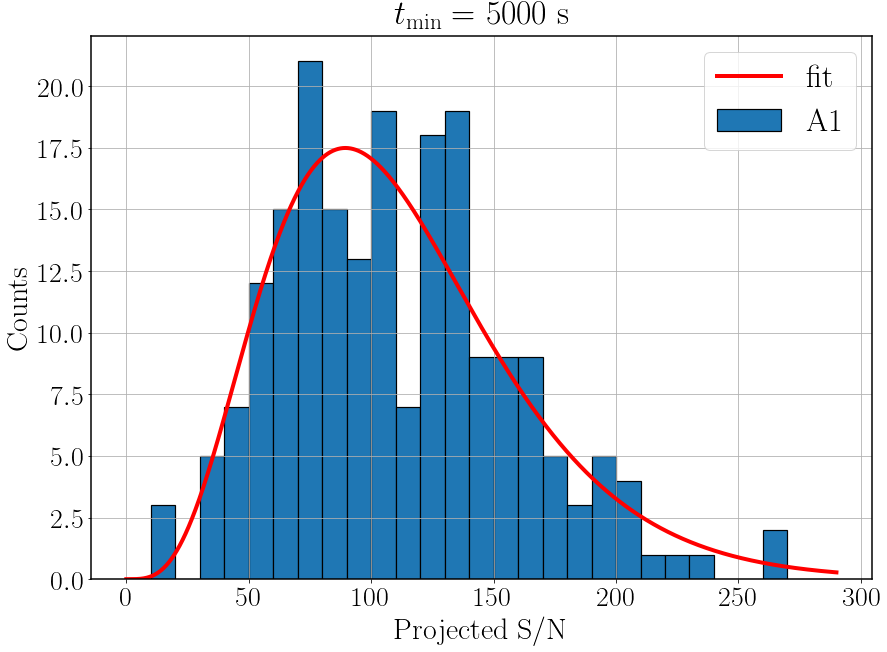

In [36]:
plt.close()

# Set the fonts. Always use big fonts.
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 30,
        "font.size": 28,
        "axes.linewidth": 1.5,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 32,
        "xtick.labelsize": 28,
        "ytick.labelsize": 28,
}
# Update the fonts
mpl.rcParams.update(nice_fonts)


plt.figure(figsize=(14,10))
plt.grid()

if ant == "A1":
    col = "C0" 
elif ant == "A2":
    col = "darkorange"      
elif ant == "A1+A2":
    col = "green"


x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, f2(x_interval_for_fit, *popt, norm), label='fit', lw=4, color='red')
plt.bar(bin_centers, bin_heights_norm * norm, width=bin_width, bottom=None, align='center', color=col, edgecolor='black', linewidth=1.2, label=ant)
#plt.scatter(bin_centers, bin_heights_norm * norm, label=ant)
plt.legend(loc='upper right')
plt.title("$t_{\mathrm{min}}=$ " + str(t_min) + " s")

plt.xlabel('Projected S/N')
plt.ylabel('Counts')

plt.savefig('histograma_scintillation' + ant + '_subints_' + str(t_min) + '.pdf', bbox_inches='tight')
plt.savefig('histograma_scintillation' + ant + '_subints_' + str(t_min) + '.png', bbox_inches='tight')

plt.show()
